# Acne Classification Using CNN
## Goal:
Build a deep learning model to classify acne types using a CNN model, while addressing dataset imbalance through oversampling and augmentation.

## ----------------------------
## 1. IMPORTS
## ----------------------------

In [ ]:

import os
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf

# from tensorflow.keras import Sequential
# from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
# from tensorflow.keras.layers import RandomFlip, RandomRotation, RandomZoom, Rescaling
# from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
# from tensorflow.keras import regularizers

from keras import Sequential, regularizers
from keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, RandomFlip, RandomRotation, RandomZoom, Rescaling
from keras.callbacks import EarlyStopping, ReduceLROnPlateau

from sklearn.utils.class_weight import compute_class_weight
import warnings
warnings.filterwarnings("ignore", category=UserWarning)

# ===========================================================================
# import required modules
# ===========================================================================

# install libraries using conda or pip
# ===================
# for array manipulations, etc.
# ===================
import random
import numpy as np

# ===================
# for visualization
# ===================
from matplotlib import pyplot as plt

# ===================
# pytorch for CNN related things
# ===================

import tarfile
import tensorflow_datasets as tfds

## 📦 2. Download Dataset

## 📂 3. Dataset Paths & Parameters

## 🧠 4. Load Datasets

In [ ]:

fname = '/Users/doncheung/Desktop/AMSI/Assignment 2/stl10_binary.tar.gz'

tar = tarfile.open(fname, "r:gz")
tar.extractall()
tar.close()

/var/folders/8x/cmwt_bmn6c94q9zn4jqg68k40000gn/T/ipykernel_5090/2231684897.py:6: DeprecationWarning: Python 3.14 will, by default, filter extracted tar archives and reject files or modify their metadata. Use the filter argument to control this behavior.
  tar.extractall()


In [ ]:
ds = tfds.load('mnist', split='train', shuffle_files=True)


TypeError: Descriptors cannot be created directly.
If this call came from a _pb2.py file, your generated code is out of date and must be regenerated with protoc >= 3.19.0.
If you cannot immediately regenerate your protos, some other possible workarounds are:
 1. Downgrade the protobuf package to 3.20.x or lower.
 2. Set PROTOCOL_BUFFERS_PYTHON_IMPLEMENTATION=python (but this will use pure-Python parsing and will be much slower).

More information: https://developers.google.com/protocol-buffers/docs/news/2022-05-06#python-updates

In [ ]:

# ----------------------------
# PARAMETERS
# ----------------------------
BATCH_SIZE = 32
IMAGE_SIZE = 128

# ----------------------------
# LOAD DATASETS
# ----------------------------
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
    train_dir, label_mode='int', image_size=(IMAGE_SIZE, IMAGE_SIZE),
    batch_size=BATCH_SIZE, shuffle=True
)

# valid_ds = tf.keras.preprocessing.image_dataset_from_directory(
#     valid_dir, label_mode='int', image_size=(IMAGE_SIZE, IMAGE_SIZE),
#     batch_size=BATCH_SIZE, shuffle=False
# )

# test_ds = tf.keras.preprocessing.image_dataset_from_directory(
#     test_dir, label_mode='int', image_size=(IMAGE_SIZE, IMAGE_SIZE),
#     batch_size=BATCH_SIZE, shuffle=False
# )

class_names = train_ds.class_names
print("Classes:", class_names)



NotADirectoryError: [Errno 20] Not a directory: '/Users/doncheung/Desktop/AMSI/Assignment 2/stl10_binary.tar.gz/train'

## 🖼️ 5. Visualize Sample Images



In [4]:
for image, label in train_ds.take(1):
    plt.figure(figsize=(10, 10))
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(image[i].numpy().astype("uint8"))

        label_index = label[i].numpy()
        plt.title(class_names[label_index])

        plt.axis("off")


NameError: name 'train_ds' is not defined

## 📊 6. Class Distribution

In [21]:
for folder in ['train', 'valid', 'test']:
    folder_path = os.path.join(base_dir, folder)
    for cls in os.listdir(folder_path):
        cls_path = os.path.join(folder_path, cls)
        if os.path.isdir(cls_path):  # Only count directories
            print(f"{folder}/{cls}:", len(os.listdir(cls_path)))

train/Whiteheads: 193
train/Papules: 621
train/Pustules: 584
train/Cyst: 645
train/Blackheads: 735
valid/Whiteheads: 49
valid/Papules: 209
valid/Pustules: 217
valid/Cyst: 206
valid/Blackheads: 240
test/Whiteheads: 57
test/Papules: 202
test/Pustules: 205
test/Cyst: 189
test/Blackheads: 265


### 📌 Observation:
Whiteheads (193 images) are underrepresented, which can bias the model.
We'll fix this using oversampling and augmentation.

## ⚖️ 7. Compute Class Weights

In [22]:
counts = [735, 645, 621, 584, 193]
classes = np.array([0,1,2,3,4])
y = np.repeat(classes, counts)
class_weight_dict = dict(zip(classes, compute_class_weight('balanced', classes=classes, y=y)))
print("Class weights:", class_weight_dict)



Class weights: {np.int64(0): np.float64(0.7559183673469387), np.int64(1): np.float64(0.8613953488372093), np.int64(2): np.float64(0.8946859903381642), np.int64(3): np.float64(0.9513698630136986), np.int64(4): np.float64(2.8787564766839377)}


## 🔧 8. Preprocessing & Normalization

In [23]:
normalization_layer = Rescaling(1./255)

train_ds = train_ds.map(lambda x, y: (normalization_layer(x), y))
valid_ds = valid_ds.map(lambda x, y: (normalization_layer(x), y))
test_ds = test_ds.map(lambda x, y: (normalization_layer(x), y))

## 🔁 9. Data Augmentation

In [24]:
data_augmentation = Sequential([
    RandomFlip("horizontal_and_vertical"),
    RandomRotation(0.15),
    RandomZoom(0.15)
])


## 🔄 10. Oversampling Minority Class (Whiteheads)

In [25]:
# Unbatch the dataset
train_ds_unbatched = train_ds.unbatch()

# Split dataset by class
class_datasets = []
for i in range(len(class_names)):
    class_datasets.append(train_ds_unbatched.filter(lambda x, y: y==i))

# Oversample minority class (Whiteheads, index 4)
target_count = max(counts)
minority_index = 4
repeat_times = target_count // counts[minority_index]
remainder = target_count % counts[minority_index]

oversampled_class = class_datasets[minority_index].repeat(repeat_times)
oversampled_class = oversampled_class.concatenate(class_datasets[minority_index].take(remainder))
class_datasets[minority_index] = oversampled_class

# Combine all classes
balanced_ds = class_datasets[0]
for ds in class_datasets[1:]:
    balanced_ds = balanced_ds.concatenate(ds)

# Shuffle, augment, and batch correctly
balanced_ds = balanced_ds.shuffle(5000)
balanced_ds = balanced_ds.map(lambda x, y: (data_augmentation(x, training=True), y))
balanced_ds = balanced_ds.batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)

### ✅ Result: 
The dataset is now balanced across all acne types.

In [26]:
valid_ds = valid_ds.cache().prefetch(tf.data.AUTOTUNE)
test_ds  = test_ds.cache().prefetch(tf.data.AUTOTUNE)

## 🧰 11. Build CNN Model

In [47]:
model = Sequential([
    Conv2D(32, (3,3), activation='tanh', input_shape=(IMAGE_SIZE, IMAGE_SIZE,3)),
    MaxPooling2D(2,2),
    Conv2D(64, (3,3), activation='tanh'),
    MaxPooling2D(2,2),
    Conv2D(128, (3,3), activation='tanh'),
    MaxPooling2D(2,2),
    Conv2D(128, (3,3), activation='tanh'),
    MaxPooling2D(2,2),
    Conv2D(256, (3,3), activation='tanh'),
    MaxPooling2D(2,2),
    Flatten(),
    Dense(128, activation='tanh', kernel_regularizer=regularizers.l2(0.001)),
    Dropout(0.5),
    Dense(len(class_names), activation='softmax')
])

model.compile(
    optimizer='adam',
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

model.summary()



Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_10 (Conv2D)              │ (None, 126, 126, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_10 (MaxPooling2D) │ (None, 63, 63, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_11 (Conv2D)              │ (None, 61, 61, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_11 (MaxPooling2D) │ (None, 30, 30, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_12 (Conv2D)              │ (None, 28, 28, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_12 (MaxPooling2D) │ (None, 14, 14, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_13 (Conv2D)              │ (None, 12, 12, 128)    │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_13 (MaxPooling2D) │ (None, 6, 6, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_14 (Conv2D)              │ (None, 4, 4, 256)      │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_14 (MaxPooling2D) │ (None, 2, 2, 256)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_2 (Flatten)             │ (None, 1024)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 128)            │       131,200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 5)              │           645 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 667,845 (2.55 MB)

 Trainable params: 667,845 (2.55 MB)

 Non-trainable params: 0 (0.00 B)

## 🏋️‍♂️ 12. Train Model


In [48]:
# ----------------------------
# CALLBACKS
# ----------------------------
early_stop = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
lr_scheduler = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3, min_lr=1e-6, verbose=1)

# ----------------------------
# TRAIN MODEL
# ----------------------------
history = model.fit(
    balanced_ds,
    validation_data=valid_ds,
    epochs=50,
    class_weight=class_weight_dict,
    callbacks=[early_stop, lr_scheduler],
    verbose=2
)

Epoch 1/50
104/104 - 16s - 153ms/step - accuracy: 0.3142 - loss: 1.9143 - val_accuracy: 0.1748 - val_loss: 2.0764 - learning_rate: 0.0010
Epoch 2/50
104/104 - 14s - 139ms/step - accuracy: 0.3476 - loss: 1.6939 - val_accuracy: 0.2704 - val_loss: 1.7241 - learning_rate: 0.0010
Epoch 3/50
104/104 - 15s - 142ms/step - accuracy: 0.3651 - loss: 1.5912 - val_accuracy: 0.2714 - val_loss: 1.7375 - learning_rate: 0.0010
Epoch 4/50
104/104 - 15s - 144ms/step - accuracy: 0.3916 - loss: 1.5381 - val_accuracy: 0.3290 - val_loss: 1.6446 - learning_rate: 0.0010
Epoch 5/50
104/104 - 15s - 143ms/step - accuracy: 0.4292 - loss: 1.4407 - val_accuracy: 0.3051 - val_loss: 1.6500 - learning_rate: 0.0010
Epoch 6/50
104/104 - 14s - 139ms/step - accuracy: 0.4443 - loss: 1.3723 - val_accuracy: 0.3702 - val_loss: 1.5296 - learning_rate: 0.0010
Epoch 7/50
104/104 - 14s - 136ms/step - accuracy: 0.4620 - loss: 1.3447 - val_accuracy: 0.4169 - val_loss: 1.4402 - learning_rate: 0.0010
Epoch 8/50
104/104 - 14s - 138ms/s

2026-01-20 17:42:55.027880: I tensorflow/core/framework/local_rendezvous.cc:407] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


104/104 - 15s - 144ms/step - accuracy: 0.7196 - loss: 0.6862 - val_accuracy: 0.6569 - val_loss: 0.9311 - learning_rate: 2.5000e-04
Epoch 26/50
104/104 - 14s - 138ms/step - accuracy: 0.7316 - loss: 0.6757 - val_accuracy: 0.6797 - val_loss: 0.9003 - learning_rate: 2.5000e-04
Epoch 27/50
104/104 - 14s - 139ms/step - accuracy: 0.7361 - loss: 0.6598 - val_accuracy: 0.6482 - val_loss: 0.9451 - learning_rate: 2.5000e-04
Epoch 28/50
104/104 - 14s - 137ms/step - accuracy: 0.7352 - loss: 0.6597 - val_accuracy: 0.6634 - val_loss: 0.9055 - learning_rate: 2.5000e-04
Epoch 29/50

Epoch 29: ReduceLROnPlateau reducing learning rate to 0.0001250000059371814.
104/104 - 14s - 138ms/step - accuracy: 0.7560 - loss: 0.6297 - val_accuracy: 0.6580 - val_loss: 0.9437 - learning_rate: 2.5000e-04
Epoch 30/50
104/104 - 15s - 139ms/step - accuracy: 0.7584 - loss: 0.6111 - val_accuracy: 0.6830 - val_loss: 0.8960 - learning_rate: 1.2500e-04
Epoch 31/50
104/104 - 14s - 136ms/step - accuracy: 0.7696 - loss: 0.5889 - v

## 📈 13. Evaluate Model

In [49]:
test_loss, test_acc = model.evaluate(test_ds)
print("Test Accuracy:", test_acc)

29/29 ━━━━━━━━━━━━━━━━━━━━ 1s 27ms/step - accuracy: 0.7451 - loss: 0.7476
Test Accuracy: 0.7450980544090271


## 🔍 14. Confusion Matrix & Classification Report

In [50]:
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns

# Get true and predicted labels for test set
y_true = []
y_pred = []

for images, labels in test_ds:
    preds = model.predict(images)
    y_true.extend(labels.numpy())
    y_pred.extend(np.argmax(preds, axis=1))

y_true = np.array(y_true)
y_pred = np.array(y_pred)



1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━

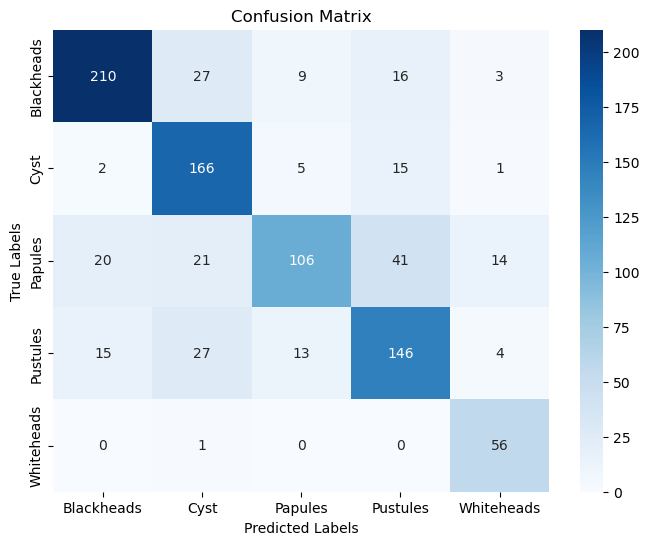

In [51]:
# ----------------------------
# CONFUSION MATRIX
# ----------------------------
cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(8,6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", 
            xticklabels=class_names, yticklabels=class_names)
plt.xlabel("Predicted Labels")
plt.ylabel("True Labels")
plt.title("Confusion Matrix")
plt.show()



In [53]:
# ----------------------------
# CLASSIFICATION REPORT
# ----------------------------
report = classification_report(y_true, y_pred, target_names=class_names)
print("\nClassification Report:\n", report)



Classification Report:
               precision    recall  f1-score   support

  Blackheads       0.85      0.79      0.82       265
        Cyst       0.69      0.88      0.77       189
     Papules       0.80      0.52      0.63       202
    Pustules       0.67      0.71      0.69       205
  Whiteheads       0.72      0.98      0.83        57

    accuracy                           0.75       918
   macro avg       0.74      0.78      0.75       918
weighted avg       0.76      0.75      0.74       918



Saved for 50 epochs (RELU):

Classification Report:
               precision    recall  f1-score   support

  Blackheads       0.68      0.77      0.72       265
        Cyst       0.64      0.72      0.68       189
     Papules       0.58      0.43      0.50       202
    Pustules       0.59      0.59      0.59       205
  Whiteheads       0.96      0.93      0.95        57

    accuracy                           0.65       918
   macro avg       0.69      0.69      0.69       918
weighted avg       0.65      0.65      0.65       918



Saved for 50 epochs (GELU):

Classification Report:
               precision    recall  f1-score   support

  Blackheads       0.88      0.93      0.90       265
        Cyst       0.85      0.95      0.90       189
     Papules       0.88      0.79      0.83       202
    Pustules       0.91      0.81      0.86       205
  Whiteheads       0.88      0.98      0.93        57

    accuracy                           0.88       918
   macro avg       0.88      0.89      0.88       918
weighted avg       0.88      0.88      0.88       918



Saved for 50 epochs (tanh):

Classification Report:
               precision    recall  f1-score   support

  Blackheads       0.85      0.79      0.82       265
        Cyst       0.69      0.88      0.77       189
     Papules       0.80      0.52      0.63       202
    Pustules       0.67      0.71      0.69       205
  Whiteheads       0.72      0.98      0.83        57

    accuracy                           0.75       918
   macro avg       0.74      0.78      0.75       918
weighted avg       0.76      0.75      0.74       918

## 📊 15. Accuracy and Loss Curves


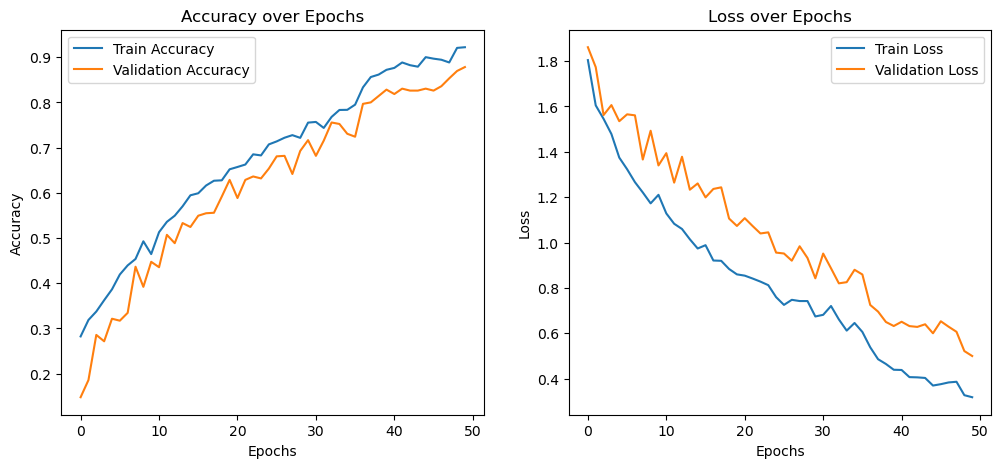

In [46]:
plt.figure(figsize=(12,5))

plt.subplot(1,2,1)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Accuracy over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.subplot(1,2,2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Loss over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()